In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os
import glob
import sys

# Plotting
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.colors as colors
import matplotlib as mpl
import cmocean
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.dates as mdates
import plotly.express as px
from matplotlib.ticker import NullFormatter
from matplotlib import rc
import seaborn as sns



def ProgressBar(Total, Progress, BarLength=20, ProgressIcon="#", BarIcon="-"):
    try:
        # You can't have a progress bar with zero or negative length.
        if BarLength <1:
            BarLength = 20
        # Use status variable for going to the next line after progress completion.
        Status = ""
        # Calcuting progress between 0 and 1 for percentage.
        Progress = float(Progress) / float(Total)
        # Doing this conditions at final progressing.
        if Progress >= 1.:
            Progress = 1
            Status = "\r\n"    # Going to the next line
        # Calculating how many places should be filled
        Block = int(round(BarLength * Progress))
        # Show this
        Bar = "[{}] {:.0f}% {}".format(ProgressIcon * Block + BarIcon * (BarLength - Block), round(Progress * 100, 0), Status)
        return Bar
    except:
        return "ERROR"


def ShowBar(Bar):
    sys.stdout.write(Bar)
    sys.stdout.flush()

In [2]:
# Analysis dataset

variable_list = ['uvel','vvel','wave_sig_ht','peak_period','Tair','sst','sss','strairx','strairy','strocnx','strocny','strcorx','strcory','strtltx','strtlty','strintx','strinty','strength','divu','shear','uatm','vatm','uocn','vocn','frzmlt','daidtd','daidtt','meltt','meltb','meltl','Tsfc','sice','uatm','vatm','frazil','congel']
num_variables = np.size(variable_list)

savepath = '/home/566/nd0349/notebooks/'
mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
year = 2019

NFSD = np.asarray([2.6884, 9.7984, 21.6721, 40.7349, 70.1407, 113.6938, 175.5771, 259.8365, 369.6202, 506.2401, 668.2091, 850.4769])
floe_binwidth = np.asarray([5.2438, 8.9763, 14.7711, 23.3545, 35.4569, 51.6493, 72.1173, 96.4015, 123.1658, 150.0741, 173.8638, 190.6719])


os.chdir(mypath)
file_dates = []
print(year)
filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'

onlyfiles = glob.glob("{path}/iceh.*{year}*".format(path=mypath, year=year))
onlyfiles.sort()
print(filename)
ds = xr.open_dataset(filename)
LN = ds.TLON.values
LT = ds.TLAT.values
# Get the total number of grid points
size = 1
for dim in np.shape(LN): size *= dim
aice_data = ds['aice'][0,:,:]
mask1 = np.ma.masked_where(LT > 0.0, aice_data)
mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
master_mask = mask1.mask | mask2.mask
mask = master_mask

X_out =  np.ma.masked_array(np.empty((size,1)), mask=mask)

# Loop over the files in that year
for filecount, file in enumerate(onlyfiles):
    progressBar = "\rProgress: " + ProgressBar(len(onlyfiles), filecount+1, 20, '#', '.')
    ShowBar(progressBar)

    # Open the file
    filename = file
    file_dates.append(np.datetime64(file[-13:-3]))
    ds = xr.open_dataset(filename)

    # Get and apply masks to remove the ocean
    aice_data = ds['aice'][0,:,:]
    mask1 = np.ma.masked_where(LT > 0.0, aice_data)
    mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
    master_mask = mask1.mask | mask2.mask
    mask = master_mask

    # Get all the variables
    for counter, exp in enumerate(variable_list):
        data = ds[exp][0,:,:]
        data_masked = np.ma.masked_where(mask, data)
        data_masked_vec = data_masked.compressed()
        row_length, = data_masked_vec.shape

        if counter == 0: 
            # First file, then initialise X_temp
            X_single_file = data_masked_vec.reshape(row_length,1)
        else:
            # Else just concatenate the new data on
            X_single_file = np.concatenate([X_single_file, data_masked_vec.reshape(row_length,1)],axis=1)

    
    
    # Add on the corresponding coordinates
    LN_masked = np.ma.masked_where(mask, LN)
    LN_vec = LN_masked.compressed()
    LT_masked = np.ma.masked_where(mask, LT)
    LT_vec = LT_masked.compressed()
    X_single_file = np.concatenate([X_single_file, LN_vec.reshape(row_length,1), LT_vec.reshape(row_length,1)],axis=1)

    if filecount == 0: 
        # Day 1, then initialise the year file
        X_year = X_single_file
        datetime_vec =  np.tile(np.datetime64(file[-13:-3]),(row_length,1))
    else:
        X_year = np.concatenate([X_year, X_single_file],axis=0)
        datetime_vec = np.concatenate([datetime_vec, np.tile(np.datetime64(file[-13:-3]),(row_length,1))],axis=0)
# Save as dataframe
df_raw = pd.DataFrame(X_year, columns = variable_list+['longitude','latitude'])#,'date'])
df_raw['date'] = datetime_vec
print(datetime_vec.shape)
df_raw = df_raw.dropna()

2019
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2019-01-01.nc
Progress: [####################] 100% 
(6776612, 1)


In [3]:
# df_raw = pd.DataFrame(X_year, columns = variable_list+['longitude','latitude'])#,'date'])
# df_raw['date'] = datetime_vec
# print(datetime_vec.shape)
# df_raw = df_raw.dropna()

savepath = '/g/data/ia40/sea-ice-classification/dataframes/'
savefilename = 'forcing_analysis_'+str(year)+'.csv'
df_raw.to_csv(savepath+savefilename)

In [4]:
df_raw.describe()

,uvel,vvel,wave_sig_ht,peak_period,Tair,sst,sss,strairx,strairy,strocnx,...,meltb,meltl,Tsfc,sice,uatm,vatm,frazil,congel,longitude,latitude
count,2.104612e+06,2.104612e+06,2.104612e+06,2.104612e+06,2.104612e+06,2.104612e+06,2.104612e+06,2.104612e+06,2.104612e+06,2.104612e+06,...,2.104612e+06,2.104612e+06,2.104612e+06,2.104612e+06,2.104612e+06,2.104612e+06,2.104612e+06,2.104612e+06,2.104612e+06,2.104612e+06
mean,3.109975e-03,2.512112e-02,9.570920e-02,1.216790e+01,-1.071627e+01,-1.892159e+00,3.409129e+01,-7.098169e-03,1.866933e-02,6.181220e-03,...,4.495217e-01,9.968138e-02,-1.180029e+01,7.660873e+00,-8.335990e-03,1.072663e+00,2.334374e-01,4.931203e-01,2.058976e+02,-6.851115e+01
std,1.305611e-01,9.884229e-02,3.807564e-01,8.012182e+00,8.276958e+00,2.045252e-01,4.813006e-01,1.605332e-01,1.268363e-01,1.480598e-01,...,9.950228e-01,1.192850e+00,8.602635e+00,3.770505e+00,6.145284e+00,5.120702e+00,4.552478e-01,6.263330e-01,1.008597e+02,5.149976e+00
min,-7.252312e-01,-3.964165e-01,0.000000e+00,0.000000e+00,-3.675251e+01,-1.968207e+00,2.745956e+01,-2.456544e+00,-1.184874e+00,-1.125189e+00,...,0.000000e+00,0.000000e+00,-4.495252e+01,2.676381e+00,-3.472032e+01,-2.040736e+01,0.000000e+00,0.000000e+00,5.000000e-01,-7.762990e+01
25%,-6.909992e-02,-3.246145e-02,1.825173e-08,1.067259e+01,-1.715197e+01,-1.926755e+00,3.391076e+01,-4.902079e-02,-2.477094e-02,-4.648057e-02,...,1.014416e-02,0.000000e+00,-1.880964e+01,5.193364e+00,-3.885379e+00,-2.101872e+00,2.201134e-02,1.735204e-02,1.515000e+02,-7.279180e+01
50%,2.313752e-03,2.328060e-02,9.661404e-05,1.477915e+01,-9.782712e+00,-1.912247e+00,3.414179e+01,3.622078e-03,1.019910e-02,-1.840724e-03,...,3.889220e-02,8.022993e-05,-1.082583e+01,6.540156e+00,5.383344e-01,1.315633e+00,1.024381e-01,3.085161e-01,2.085000e+02,-6.870660e+01
75%,7.872257e-02,8.492424e-02,1.175724e-02,1.479290e+01,-2.883293e+00,-1.898162e+00,3.438486e+01,5.722608e-02,6.033091e-02,4.006814e-02,...,2.888558e-01,3.137192e-03,-3.813813e+00,8.924461e+00,4.226417e+00,4.348951e+00,2.576737e-01,6.959293e-01,3.055000e+02,-6.503162e+01
max,5.654863e-01,7.103491e-01,9.831613e+00,9.999323e+02,1.708173e+00,3.868543e+00,3.509861e+01,1.143510e+00,2.092146e+00,2.339677e+00,...,1.887650e+01,8.701248e+01,1.124698e-05,3.090362e+01,2.357658e+01,3.176237e+01,1.359411e+01,7.211465e+00,3.595000e+02,-5.303830e+01


In [6]:
# Read in data 
year = 2019
df = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/forcing_analysis_'+str(year)+'.csv')
df_kmeans = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/kmeans_'+str(year)+'.csv')
df['k'] = df_kmeans['k']
unique_dates = df['date'].unique()
df.groupby('k').describe()

Unnamed: 0                                                            \
       count          mean           std     min        25%        50%   
k                                                                        
0   243101.0  3.596447e+06  1.932728e+06  6155.0  2101921.0  3516027.0   
1   547018.0  3.431001e+06  1.297324e+06  6483.0  2404088.5  3368060.5   
2  1314493.0  4.014657e+06  1.761368e+06   564.0  2743370.0  4267875.0   

                              uvel            ... longitude          latitude  \
         75%        max      count      mean  ...       75%    max      count   
k                                             ...                               
0  5295206.0  6771173.0   243101.0  0.066328  ...     272.5  359.5   243101.0   
1  4419365.5  6771131.0   547018.0  0.033754  ...     275.5  359.5   547018.0   
2  5478721.0  6771130.0  1314493.0 -0.021334  ...     310.5  359.5  1314493.0   

                                                                            
        mean       std      min       25%        50%        75%        max  
k                                                                           
0 -63.715727  4.782258 -77.6299 -67.22025 -63.846264 -59.922382 -53.038300  
1 -65.336016  4.243378 -77.6299 -68.22556 -65.601395 -61.953148 -53.038300  
2 -70.719298  4.184834 -77.6299 -74.10892 -71.306650 -67.730190 -57.005028  

[3 rows x 312 columns]

# Stresses

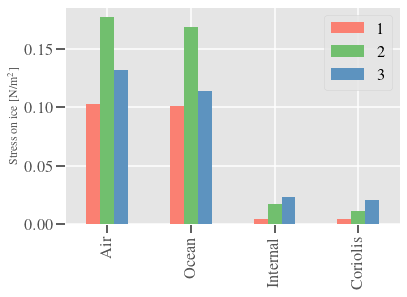

In [202]:
# create DataFrame
plt.style.use("ggplot")
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

df_magnitude = pd.DataFrame({'k': df["k"].values,
                             "date": df["date"].values,
                             "strair": np.sqrt(np.square(df["strairx"])+np.square(df["strairy"])),
                             "strocn": np.sqrt(np.square(df["strocnx"])+np.square(df["strocny"])),
                             "strint": np.sqrt(np.square(df["strintx"])+np.square(df["strinty"])),
                             "strcor": np.sqrt(np.square(df["strcorx"])+np.square(df["strcory"])),
                            })
                             
#df_magnitude["strair"] = np.sqrt(np.square(df["strairx"])+np.square(df["strairy"]))
#df_magnitude["strocn"] = np.sqrt(np.square(df["strairx"])+np.square(df["strairy"]))


df_grouped = df_magnitude[["strair", "strocn", "strint", "strcor", "k"]].groupby('k').mean(numeric_only=True)
#df_grouped["dafsd_latm"] = df_grouped["dafsd_latm"]*100#.values*(10^5)
#df_grouped["dafsd_latg"] = df_grouped["dafsd_latg"]*10000


df_plot = pd.DataFrame({'1': df_grouped.iloc[0,:].values,
                        '2': df_grouped.iloc[1,:].values,
                        '3': df_grouped.iloc[2,:].values},
                        index=['Air', 'Ocean', 'Internal', 'Coriolis'])
 
 
# create stacked bar chart for monthly temperatures
#df_plot.plot(kind='bar', stacked=True, color=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
ax = df_plot.plot.bar(color=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
#plt.xticks(range(3),['Shear ($10^{1}$)','Divergence','Strength ($10^{4}$)'])

# labels for x & y axis
#plt.xlabel('Floe size mechanisms')
plt.ylabel('Stress on ice [N/m$^2$]')
 
# title of plot
#plt.title('Monthly Temperatures in a year')
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'stresses_bar.png', dpi = 600, bbox_inches="tight")

In [198]:
# Timeseries data
df_magnitude['date'] = pd.to_datetime(df_magnitude['date'], format="%Y-%m-%d")
df_timeseries = df_magnitude.groupby(['date', 'k']).rolling(7).mean(numeric_only=True)
df_timeseries

strair    strocn    strint    strcor
date       k                                                
2019-01-01 0 1064          NaN       NaN       NaN       NaN
             1178          NaN       NaN       NaN       NaN
             1179          NaN       NaN       NaN       NaN
             1180          NaN       NaN       NaN       NaN
             1287          NaN       NaN       NaN       NaN
...                        ...       ...       ...       ...
2019-12-31 2 2104564  0.067649  0.066649  0.000143  0.012222
             2104565  0.066888  0.065904  0.000131  0.012044
             2104566  0.066575  0.065605  0.000129  0.011883
             2104567  0.066646  0.065687  0.000135  0.011777
             2104568  0.066862  0.065918  0.000138  0.011711

[2104612 rows x 4 columns]

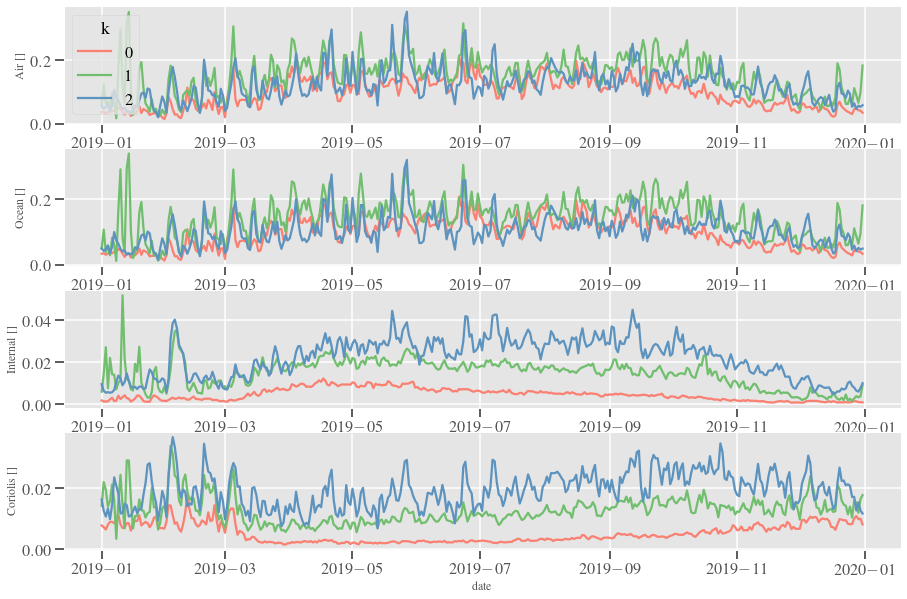

In [201]:
# Time series plot
plt.style.use("ggplot")
#sns.set_context("talk")
# set figure size
#plt.figure(figsize=(12,6))
fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharey=False)
#fig.suptitle('Initial Pokemon - 1st Generation')


# Time series plot with Seaborn lineplot()
sns.lineplot(ax=axes[0], x="date", y="strair", hue="k",
            data=df_timeseries, errorbar=None,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[0].set(ylabel='Air []')

sns.lineplot(ax=axes[1], x="date", y="strocn", hue="k",
            data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[1].set(ylabel='Ocean []')

sns.lineplot(ax=axes[2], x="date", y="strint", hue="k",
            data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[2].set(ylabel='Internal []')
    
sns.lineplot(ax=axes[3], x="date", y="strcor", hue="k",
            data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[3].set(ylabel='Coriolis []')


plt.savefig(savepath+'stresses_ts.png', dpi = 600, bbox_inches="tight")

# Dynamics

In [6]:
# Dynamics

# create DataFrame
plt.style.use("ggplot")
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

df_dyn = pd.DataFrame({'k': df["k"].values,
                             "date": df["date"].values,
                             "uvel": df["uvel"].values,
                             "vvel": df["vvel"].values,
                             "uatm": df["uatm"].values,
                             "vatm": df["vatm"].values,
                             "vel": np.sqrt(np.square(df["uvel"])+np.square(df["vvel"])),
                             "shear": df["shear"].values,
                             "divu": df["divu"].values,
                             "strength": df["strength"].values,
                            })
                             
#df_magnitude["strair"] = np.sqrt(np.square(df["strairx"])+np.square(df["strairy"]))
#df_magnitude["strocn"] = np.sqrt(np.square(df["strairx"])+np.square(df["strairy"]))


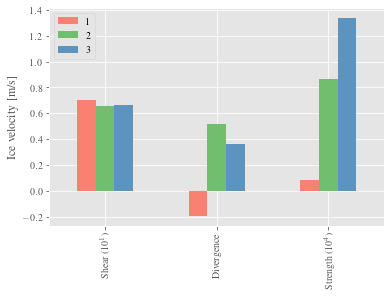

In [7]:
df_grouped = df_dyn[["shear", "divu", "strength", "k"]].groupby('k').mean(numeric_only=True)
#df_grouped["dafsd_latm"] = df_grouped["dafsd_latm"]*100#.values*(10^5)
#df_grouped["dafsd_latg"] = df_grouped["dafsd_latg"]*10000
df_grouped['shear'] = df_grouped['shear']*0.1
df_grouped['strength'] = df_grouped['strength']*0.0001

df_plot = pd.DataFrame({'1': df_grouped.iloc[0,:].values,
                        '2': df_grouped.iloc[1,:].values,
                        '3': (df_grouped.iloc[2,:].values)},
                        index=['shear', 'divu', 'strength'])
 
 
# create stacked bar chart for monthly temperatures
#df_plot.plot(kind='bar', stacked=True, color=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
ax = df_plot.plot.bar(color=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
plt.xticks(range(3),['Shear ($10^{1}$)','Divergence','Strength ($10^{4}$)'])

#plt.ylabel('Ice velocity [m/s]')
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'dyn_shear_bar.png', dpi = 600, bbox_inches="tight")

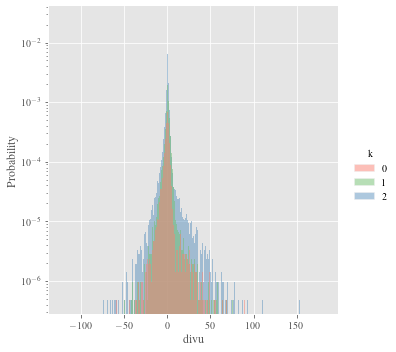

In [22]:
sns.displot(data=df_dyn, x="divu", hue="k", stat="probability",
            palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
plt.yscale('log')
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'div_bar.png', dpi = 600, bbox_inches="tight")

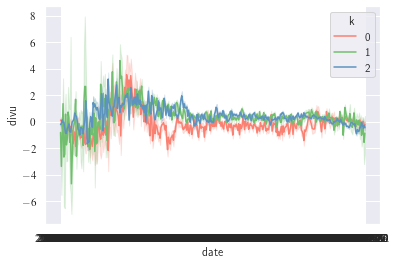

In [26]:
df_dyn['date'] = pd.to_datetime(df_dyn['date'], format="%Y-%m-%d")
sns.lineplot(data=df_dyn, x="date", hue="k", y="divu",
            palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
#plt.yscale('log')
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'div_ts.png', dpi = 600, bbox_inches="tight")

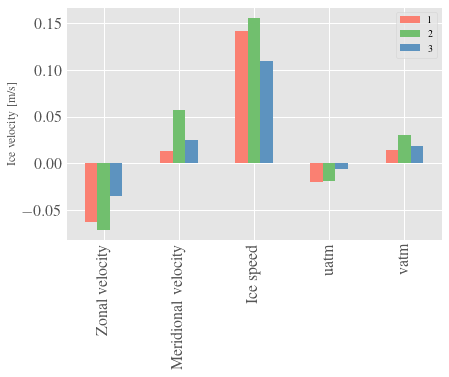

In [35]:
df_grouped = df_dyn[["uvel", "vvel", "vel","uatm","vatm", "k"]].groupby('k').mean(numeric_only=True)
df_grouped["uatm"] = df_grouped["uatm"].values*(0.01)
df_grouped["vatm"] = df_grouped["vatm"].values*(0.01)
#df_grouped["dafsd_latm"] = df_grouped["dafsd_latm"]*100#.values*(10^5)
#df_grouped["dafsd_latg"] = df_grouped["dafsd_latg"]*10000


df_plot = pd.DataFrame({'1': df_grouped.iloc[0,:].values,
                        '2': df_grouped.iloc[1,:].values,
                        '3': df_grouped.iloc[2,:].values},
                        index=['uvel', 'vvel', 'vel', 'uatm', 'vatm'])
 
 
# create stacked bar chart for monthly temperatures
#df_plot.plot(kind='bar', stacked=True, color=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
ax = df_plot.plot.bar(color=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
plt.xticks(range(5),['Zonal velocity','Meridional velocity','Ice speed', 'uatm', 'vatm'])

# labels for x & y axis
#plt.xlabel('Floe size mechanisms')
plt.ylabel('Ice velocity [m/s]')
 
# title of plot
#plt.title('Monthly Temperatures in a year')
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'velocity_bar.png', dpi = 600, bbox_inches="tight")

In [38]:
df_dyn['date'] = pd.to_datetime(df_dyn['date'], format="%Y-%m-%d")
df_timeseries = df_dyn.groupby(['date', 'k']).rolling(7).mean(numeric_only=True)

[Text(0, 0.5, 'vatm []')]

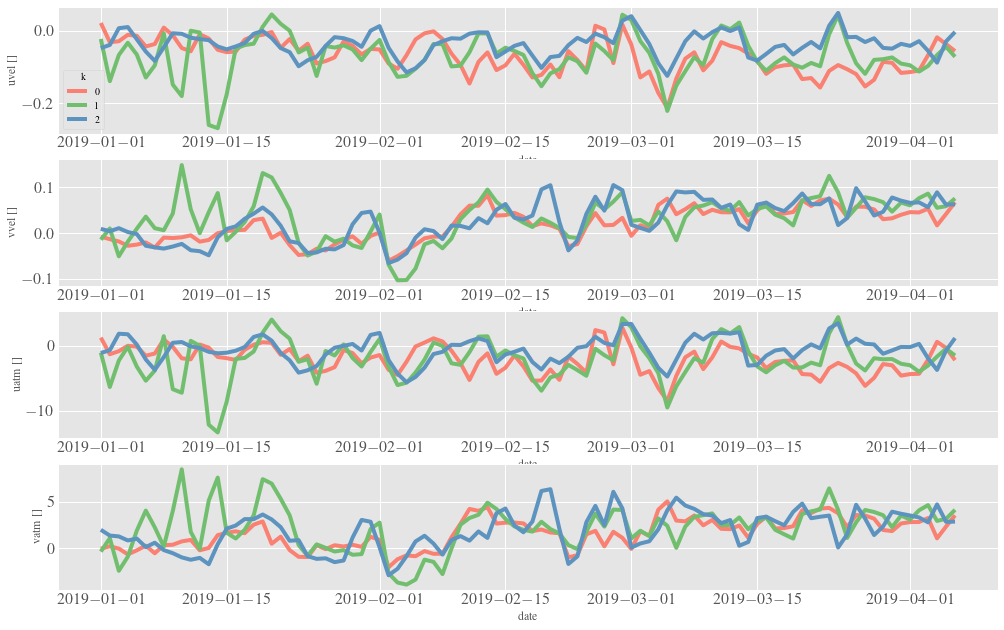

In [40]:
# Time series plot
plt.style.use("ggplot")
#sns.set_context("talk")
#plt.figure(figsize=(12,6))
fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharey=False)
#fig.suptitle('Initial Pokemon - 1st Generation')

# Time series plot with Seaborn lineplot()

sns.lineplot(ax=axes[0], x="date", y="uvel", hue="k",
             data=df_timeseries, errorbar=None,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[0].set(ylabel='uvel []')
#axes[0].set_title('Horizontal veloci')

sns.lineplot(ax=axes[1], x="date", y="vvel", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[1].set(ylabel='vvel []')
# #axes[1].set_ylim((-0.1,0.1))

sns.lineplot(ax=axes[2], x="date", y="uatm", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[2].set(ylabel='uatm []')

sns.lineplot(ax=axes[3], x="date", y="vatm", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[3].set(ylabel='vatm []')
#axes[2].set_ylim((0,0.25))
#axes[2].set_title('Internal')
    
#axes[2].set_ylim((0,0.1))
# axis labels
#plt.xlabel("Date", size=14)
#plt.ylabel("Daily New Cases", size=14)
# save image as PNG file

#df_magnitude
#plt.savefig(savepath+'dynamics_ts.png', dpi = 600, bbox_inches="tight")


In [191]:
# Timeseries data
df_dyn['date'] = pd.to_datetime(df_dyn['date'], format="%Y-%m-%d")
df_timeseries = df_dyn.groupby(['date', 'k']).rolling(7).mean(numeric_only=True)
#df_timeseries
#df_timeseries['uvel_14day_ave'] = df_dyn.groupby(['date', 'k']).uvel.rolling(21).mean()#.shift(-3)
#df_timeseries['vvel_14day_ave'] = df_dyn.groupby(['date', 'k']).vvel.rolling(21).mean()#.shift(-3)
#df_timeseries['vel_14day_ave'] = df_dyn.groupby(['date', 'k']).vel.rolling(21).mean()#.shift(-3)

#df_timeseries = df_timeseries.groupby('k').rolling(2).mean()


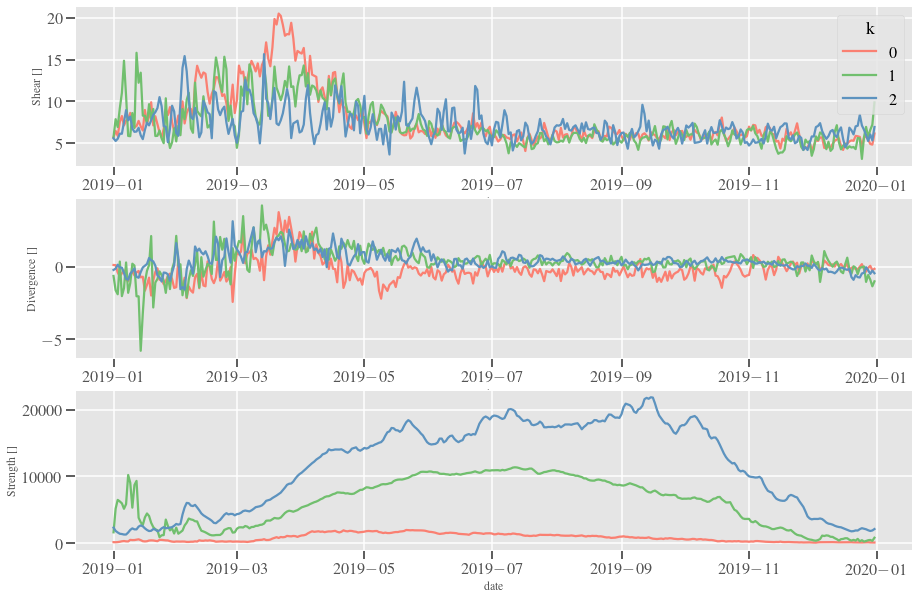

In [192]:
# Time series plot
plt.style.use("ggplot")
#sns.set_context("talk")
#plt.figure(figsize=(12,6))
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharey=False)
#fig.suptitle('Initial Pokemon - 1st Generation')

# Time series plot with Seaborn lineplot()

sns.lineplot(ax=axes[0], x="date", y="shear", hue="k",
             data=df_timeseries, errorbar=None,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[0].set(ylabel='Shear []')
#axes[0].set_title('Horizontal veloci')

sns.lineplot(ax=axes[1], x="date", y="divu", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[1].set(ylabel='Divergence []')
# #axes[1].set_ylim((-0.1,0.1))

sns.lineplot(ax=axes[2], x="date", y="strength", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[2].set(ylabel='Strength []')
#axes[2].set_ylim((0,0.25))
#axes[2].set_title('Internal')
    
#axes[2].set_ylim((0,0.1))
# axis labels
#plt.xlabel("Date", size=14)
#plt.ylabel("Daily New Cases", size=14)
# save image as PNG file

#df_magnitude
plt.savefig(savepath+'dynamics_ts.png', dpi = 600, bbox_inches="tight")


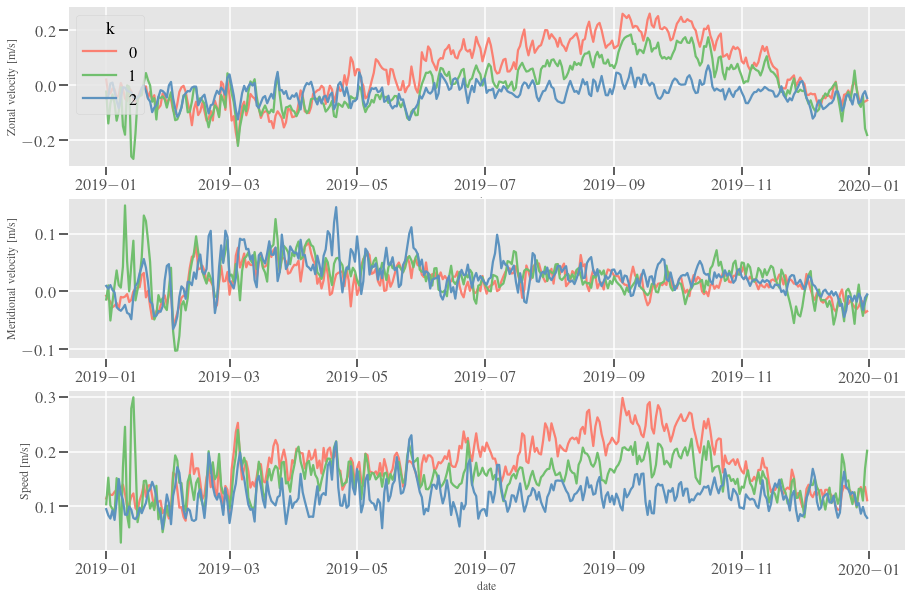

In [193]:
# Velocity time series plot
plt.style.use("ggplot")
#sns.set_context("talk")
#plt.figure(figsize=(12,6))
fig, axes = plt.subplots(5, 1, figsize=(15, 10), sharey=False)
#fig.suptitle('Initial Pokemon - 1st Generation')

# Time series plot with Seaborn lineplot()

sns.lineplot(ax=axes[0], x="date", y="uvel", hue="k",
             data=df_timeseries, errorbar=None,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[0].set(ylabel='Zonal velocity [m/s]')
#axes[0].set_title('Horizontal veloci')

sns.lineplot(ax=axes[1], x="date", y="vvel", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[1].set(ylabel='Meridional velocity [m/s]')
# #axes[1].set_ylim((-0.1,0.1))

sns.lineplot(ax=axes[2], x="date", y="vel", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[2].set(ylabel='Speed [m/s]')

sns.lineplot(ax=axes[2], x="date", y="uatm", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[3].set(ylabel='uatm [m/s]')

sns.lineplot(ax=axes[2], x="date", y="vatm", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[4].set(ylabel='vatm [m/s]')
#axes[2].set_ylim((0,0.25))
#axes[2].set_title('Internal')
    
#axes[2].set_ylim((0,0.1))
# axis labels
#plt.xlabel("Date", size=14)
#plt.ylabel("Daily New Cases", size=14)
# save image as PNG file

#df_magnitude
plt.savefig(savepath+'velocity_ts.png', dpi = 600, bbox_inches="tight")


# Melting

# Melting

<Figure size 1279.68x720 with 0 Axes>

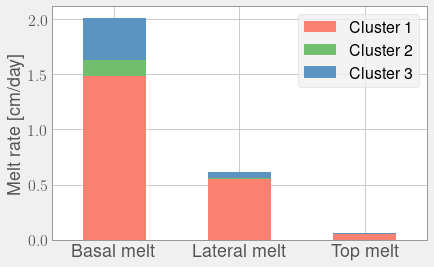

In [21]:
# Melting
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
mpl.rcParams.update({'font.size': 22})

mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 

fig = plt.figure(figsize=(13.33,7.5), dpi=96)
plt.style.use("fivethirtyeight")
mpl.rcParams["axes.edgecolor"] = [0.6, 0.6, 0.6]
mpl.rcParams["axes.linewidth"] = 1.0

# create DataFrame
df_melt = pd.DataFrame({'k': df["k"].values,
                             "date": df["date"].values,
                             "meltt": df["meltt"].values,
                             "meltl": df["meltl"].values,
                             "meltb": df["meltb"].values,
                            })
                             
#df_magnitude["strair"] = np.sqrt(np.square(df["strairx"])+np.square(df["strairy"]))
#df_magnitude["strocn"] = np.sqrt(np.square(df["strairx"])+np.square(df["strairy"]))


df_grouped = df_melt[["meltb", "meltl", "meltt", "k"]].groupby('k').mean(numeric_only=True)
#df_grouped["dafsd_latm"] = df_grouped["dafsd_latm"]*100#.values*(10^5)
#df_grouped["dafsd_latg"] = df_grouped["dafsd_latg"]*10000


df_plot = pd.DataFrame({'1': df_grouped.iloc[0,:].values,
                        '2': df_grouped.iloc[1,:].values,
                        '3': df_grouped.iloc[2,:].values},
                        index=['Basal melt', 'Lateral melt', 'Top melt'])
 
 
# create stacked bar chart for monthly temperatures

#fig, axes = plt.subplots(1, 1, figsize=(9, 6), sharey=True)
ax = df_plot.plot(kind='bar', stacked=True, 
             color=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)],
             linewidth=2)
 
# labels for x & y axis
#plt.xlabel('Floe size mechanisms')
ax.set_facecolor((1.0, 1.0, 1.0))
plt.legend(['Cluster 1','Cluster 2','Cluster 3'], fontsize=16)
plt.xticks(rotation = 0, fontsize=18)
plt.ylabel('Melt rate [cm/day]', fontsize=18)

 
# title of plot
#plt.title('Monthly Temperatures in a year')
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'melt_bar.png', dpi = 1000, bbox_inches="tight", transparent=False)
#import matplotlib2tikz
#matplotlib2tikz.save(savepath+'melt_bar.tex')


In [177]:
# Timeseries data
# df_timeseries = df_melt.groupby(['date', 'k']).mean(numeric_only=True)
# #df_timeseries
# df_timeseries['meltb_14day_ave'] = df_timeseries.meltb.rolling(7).mean().shift(-3)
# df_timeseries['meltl_14day_ave'] = df_timeseries.meltl.rolling(7).mean().shift(-3)
# df_timeseries['meltt_14day_ave'] = df_timeseries.meltt.rolling(7).mean().shift(-3)

df_melt['date'] = pd.to_datetime(df_melt['date'], format="%Y-%m-%d")
df_timeseries = df_melt.groupby(['date', 'k']).rolling(14).mean(numeric_only=True)


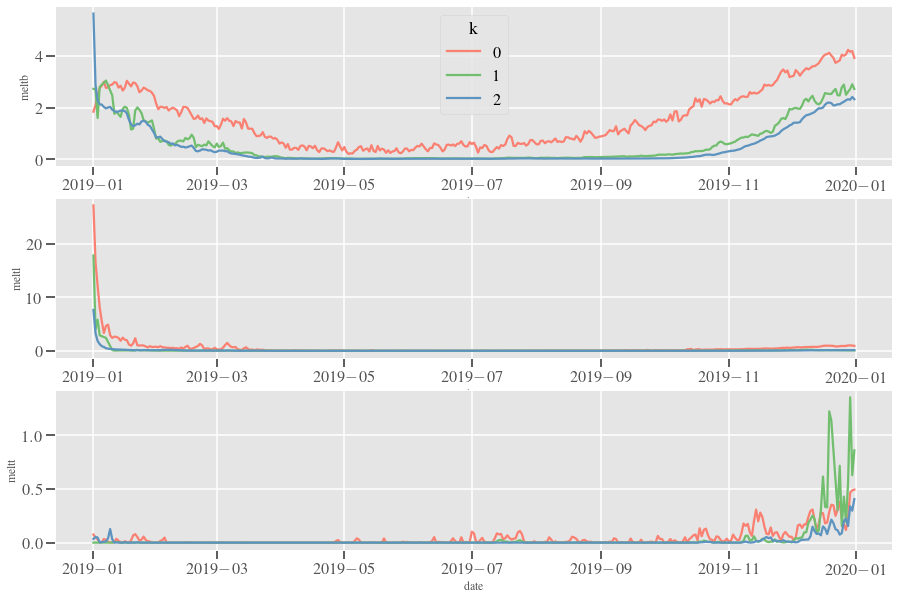

In [178]:
# Time series plot
plt.style.use("ggplot")
#sns.set_context("talk")
# set figure size
#plt.figure(figsize=(12,6))
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharey=False)
#fig.suptitle('Initial Pokemon - 1st Generation')


# Time series plot with Seaborn lineplot()

sns.lineplot(ax=axes[0], x="date", y="meltb", hue="k",
             data=df_timeseries, errorbar=None,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
#plt.ylim((0,10))
#axes[0].set_title('Horizontal veloci')

sns.lineplot(ax=axes[1], x="date", y="meltl", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
#axes[1].set_ylim((-0.1,0.1))

sns.lineplot(ax=axes[2], x="date", y="meltt", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])


plt.savefig(savepath+'melt_ts.png', dpi = 600, bbox_inches="tight")


## Ice formation

## Ice formation

<Figure size 1279.68x720 with 0 Axes>

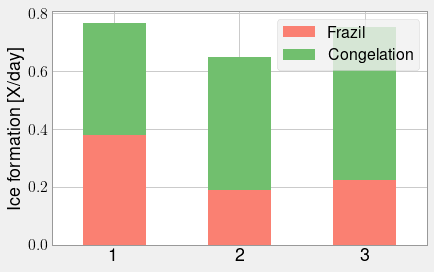

In [15]:
# Frazil vs congelation
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
mpl.rcParams.update({'font.size': 22})

mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 

fig = plt.figure(figsize=(13.33,7.5), dpi=96)
plt.style.use("fivethirtyeight")
mpl.rcParams["axes.edgecolor"] = [0.6, 0.6, 0.6]
mpl.rcParams["axes.linewidth"] = 1.0

# create DataFrame
df_frazil = pd.DataFrame({'k': df["k"].values,
                             "date": df["date"].values,
                             "frazil": df["frazil"].values,
                             "congel": df["congel"].values,
                            })
                             

df_grouped = df_melt[["frazil", "congel", "k"]].groupby('k').mean(numeric_only=True)

df_plot = pd.DataFrame({'Frazil': df_grouped.iloc[:,0].values,
                        'Congelation': df_grouped.iloc[:,1].values},
                        index=['1', '2', '3'])
 
 
# create stacked bar chart for monthly temperatures

#fig, axes = plt.subplots(1, 1, figsize=(9, 6), sharey=True)
ax = df_plot.plot(kind='bar', stacked=True, 
             color=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)],
             linewidth=2)
 
# labels for x & y axis
#plt.xlabel('Floe size mechanisms')
ax.set_facecolor((1.0, 1.0, 1.0))
plt.legend(['Frazil','Congelation'], fontsize=16)
plt.xticks(rotation = 0, fontsize=18)
plt.ylabel('Ice formation [X/day]', fontsize=18)


savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'frazil_bar.png', dpi = 1000, bbox_inches="tight", transparent=False)
#import matplotlib2tikz
#matplotlib2tikz.save(savepath+'melt_bar.tex')


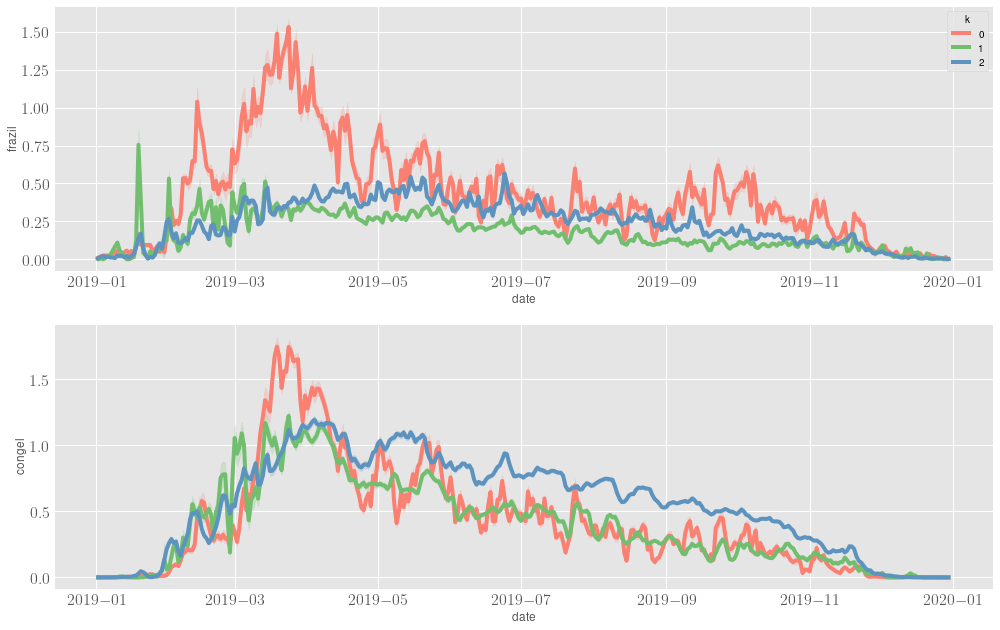

In [21]:
# Time series plot
df_frazil['date'] = pd.to_datetime(df_frazil['date'], format="%Y-%m-%d")
df_timeseries = df_frazil.groupby(['date', 'k']).rolling(14).mean(numeric_only=True)

plt.style.use("ggplot")
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharey=False)

sns.lineplot(ax=axes[0], x="date", y="frazil", hue="k",
             data=df_timeseries,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
#plt.ylim((0,10))

sns.lineplot(ax=axes[1], x="date", y="congel", hue="k",
             data=df_timeseries, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
#axes[1].set_ylim((-0.1,0.1))

plt.savefig(savepath+'frazil_ts.png', dpi = 600, bbox_inches="tight")
